<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Natural%20Language%20Processing/Text_classification_with_TensorFlow_Hub_Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [8]:
print('TF version',tf.__version__)
print('Eager mode',tf.executing_eagerly())
print('Hub version',hub.__version__)
print('GPU available' if tf.config.list_physical_devices('GPU') else 'GPU not available')

TF version 2.5.0
Eager mode True
Hub version 0.12.0
GPU available


## Download the IMDB dataset

In [10]:
(train_ds, val_ds, test_ds),metadata = tfds.load(name="imdb_reviews",
                                                 split=['train[:60%]', 'train[60%:]', 'test'],
                                                 as_supervised=True,
                                                 with_info=True)

## Build the model
The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many hidden units to use for each layer?

**One way to represent the text is to convert sentences into embeddings vectors**.

 Use a pre-trained text embedding as the first layer, which will have three advantages:
* You don't have to worry about text preprocessing,
* Benefit from transfer learning,
* the embedding has a fixed size, so it's simpler to process.


For example use a pre-trained text embedding model from TensorFlow Hub called `google/nnlm-en-dim50/2`.

There are many other pre-trained text embeddings from TFHub that can be used for creating an embedding layer

* `google/nnlm-en-dim128/2` - trained with the same NNLM architecture on the same data as `google/nnlm-en-dim50/2`, but with a larger embedding dimension. Larger dimensional embeddings can improve on your task but it may take longer to train your model.

* `google/nnlm-en-dim128-with-normalization/2` - the same as `google/nnlm-en-dim128/2`, but with additional text normalization such as removing punctuation. This can help if the text in your task contains additional characters or punctuation.

* `google/universal-sentence-encoder/4` - a much larger model yielding 512 dimensional embeddings trained with a deep averaging network (DAN) encoder.


Create a Keras layer that uses a TensorFlow Hub model to embed the sentences,  Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.

In [12]:
from tensorflow.python.keras.engine.sequential import relax_input_shape
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [14]:
train_text , train_label = next(iter(train_ds))

print('Text : ',train_text)
print('Label : ',train_label)

encoding = hub_layer(tf.expand_dims(train_text,-1))

print('Encoding : ', encoding)

Text :  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label :  tf.Tensor(0, shape=(), dtype=int64)
Encoding :  tf.Tensor(
[[ 0.5423195  -0.0119017   0.06337538  0.06862972 -0.16776837 -0.10581174
   0.16865303 -0.04998824 -0.31148055  0.07910346  0.15442263  0.01488662
   0.03930153  0.19772711 -0

In [17]:

# model
model = tf.keras.Sequential([
                             hub_layer,
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 48,190,651
Trainable params: 48,190,651
Non-trainable params: 0
_________________________________________________________________


* The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that you are using (`google/nnlm-en-dim50/2`) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (`num_examples, embedding_dimension`). For this NNLM model, the embedding_dimension is 50.

* A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation),  use the `binary_crossentropy` loss function.

* This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally,** `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions**, or in our case, between the ground-truth distribution and the predictions.

*  when you are exploring regression problems (say, to predict the price of a house), you'll use another loss function called `mean squared error`.

## Optimize the data 
Important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.


In [18]:
def config_for_performance(ds, train=False):
  if train:
    ds = ds.shuffle(10000)
  ds = ds.batch(512)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
train_ds = config_for_performance(train_ds)
val_ds = config_for_performance(val_ds)
test_ds = config_for_performance(test_ds)

## Training

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/10
30/30 [==============================] - 7s 143ms/step - loss: 0.6854 - accuracy: 0.5074 - val_loss: 0.6368 - val_accuracy: 0.5425
Epoch 2/10
30/30 [==============================] - 4s 134ms/step - loss: 0.5902 - accuracy: 0.6158 - val_loss: 0.5683 - val_accuracy: 0.6391
Epoch 3/10
30/30 [==============================] - 4s 136ms/step - loss: 0.5132 - accuracy: 0.7221 - val_loss: 0.5068 - val_accuracy: 0.7307
Epoch 4/10
30/30 [==============================] - 4s 135ms/step - loss: 0.4407 - accuracy: 0.7979 - val_loss: 0.4535 - val_accuracy: 0.7843
Epoch 5/10
30/30 [==============================] - 4s 135ms/step - loss: 0.3770 - accuracy: 0.8445 - val_loss: 0.4109 - val_accuracy: 0.8140
Epoch 6/10
30/30 [==============================] - 5s 155ms/step - loss: 0.3237 - accuracy: 0.8789 - val_loss: 0.3790 - val_accuracy: 0.8281
Epoch 7/10
30/30 [==============================] - 4s 138ms/step - loss: 0.2817 - accuracy: 0.8999 - val_loss: 0.3556 - val_accuracy: 0.8413
Epoch 

## Evaluation


In [22]:
# evaluation

loss, accuracy = model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

49/49 [==============================] - 5s 98ms/step - loss: 0.3327 - accuracy: 0.8430
Loss 0.332743763923645
Accuracy 0.842960000038147


## Learning Curves

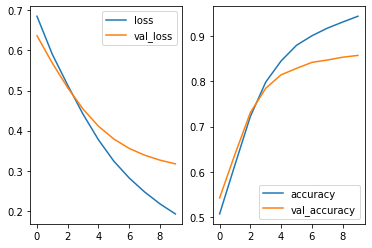

In [33]:
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'],label='loss')
plt.plot(history.epoch, history.history['val_loss'],label='val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'],label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()